In [9]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [143]:
def f(xs):

    if not isinstance(xs, np.ndarray):
        return 3*math.sin(xs-2)
    
    ys = []
    for x in xs:
        ys.append(3*math.sin(x-2))
    return ys


In [146]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

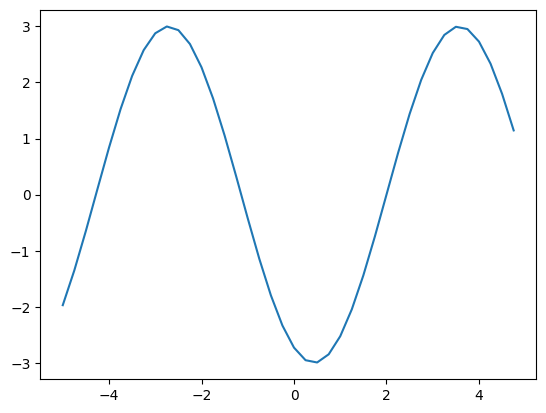

In [147]:
plt.plot(xs,ys)

In [148]:
# some derivative visualization stuff
h = 0.0000001
x = -3.0
(f(x + h) - f(x))/h

0.8509864102279607

In [149]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [150]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c 

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [151]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self,data, _children=(), _op='', label = ''):
        self._backward = lambda: None
        self.grad = 0.0
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # repr used when we print object
    def __repr__(self):
        return f"Value(data={self.data})" 
    
    def __radd__(self, other):
        return self + other
    
    def __add__(self, other):

        # if other is a constant then we wrap it in Value obj
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward

        return out

    def __sub__(self, other):
        return self + (-other)
    
    # wrapper for negation, we can simply avoid having to write
    # script for sub by using what we already have
    def __neg__(self):
        return self * -1
    
    def __mul__(self, other):

        # if other is constant we wrap it
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    # python will try to default if __mul__ does not work
    def __rmul__(self, other): # other * self, case if we have 2 * Val obj
        return self * other
    

    def __truediv__(self, other): # divide 
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * ( self.data ** (other-1) ) * out.grad

        out._backward = _backward

        return out 

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        
        #builing topological graph for backprop,
        #we only append the parent node until all children are processed
        #this allows us to visit all nodes sequentially in reverse 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        self.grad = 1.0
        build_topo(self)


        for node in reversed(topo):
            node._backward()
        




In [21]:
a = Value(2.0)
b = Value(4.0)
a/b
#a * (1/b)
#a * (b**-1)
a-b


Value(data=-2.0)

In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f ; L.label = 'L'
L

Value(data=-8.0)

In [18]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

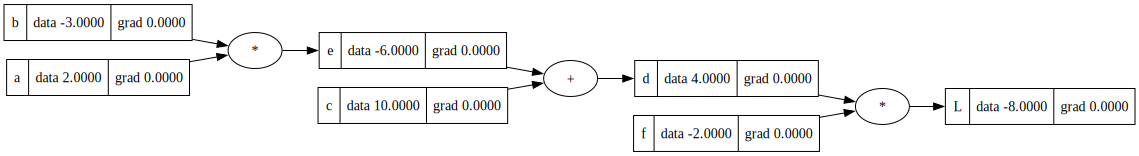

In [24]:
draw_dot(L)

In [25]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b;
d = e+c
L = d*f 

print(L.data)

-8.0


In [14]:
# want
# dL / da
# dL / db

# e = a*b

# dL/da = de/da dd/de dL/dd

#  =  -3 * 1.0 * -2 = 6

# dL/db  = 2.0 * 1.0 8 -2 = -4.0

In [14]:
a.grad = 6.0
b.grad = -4.0

In [ ]:
# dL / dc
# dL/ de
# dd / dc = 1.0
# dd/ de = 1.0

# d = c + e

#Want
# dl / dc = dL / dd * dd / dc

#Know
#dL / dd
#dd / dc = 1.0


In [15]:
e.grad = -2.0 
c.grad = -2.0

In [17]:
# L = d*f
# dL/dd = f

In [16]:
f.grad = 4.0
d.grad = -2.0

In [17]:
# derivative of L with respect to L is 1
L.grad = 1.0

In [26]:
# limt def of derivative
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'

    L2 = L.data

    print((L2-L1)/h)

lol()

-3.9999999999995595


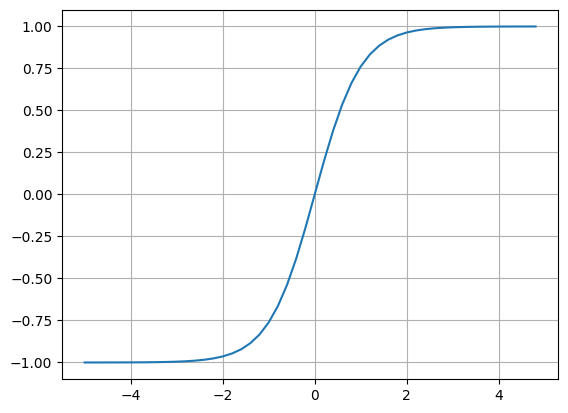

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [28]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



In [29]:
# even thought I have a backprop function for automation
# this is just for theoretrical / understanding backprop proccess

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad 
w1.grad = x1.data * x1w1.grad 
x1.grad = w1.data * x1w1.grad

# when we have a plus the backprop gradient simply flows through the next node
x1w1.grad = 0.5
x2w2.grad = 0.5


x1w1x2w2.grad = 0.5
b.grad = 0.5

n.grad = 1 - o.data**2

# o = tanh(n)
# do / dn = 1 - o**2

o.grad = 1.0

In [30]:
o.backward()

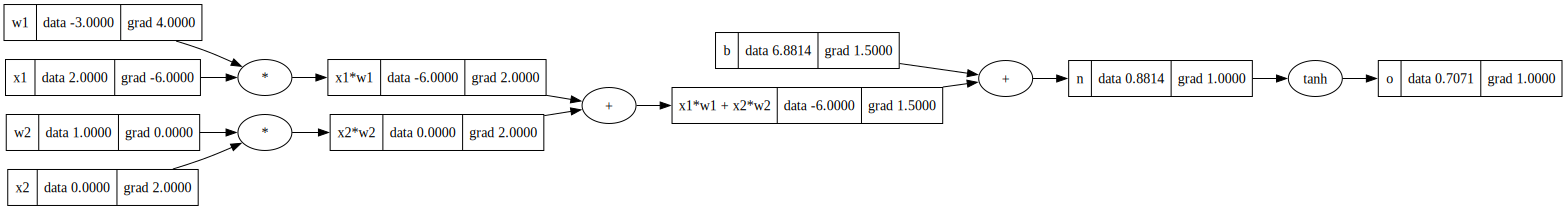

In [31]:
draw_dot(o)

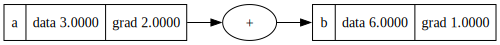

In [32]:
a = Value(3.0, label='a')
b  = a+a ; b.label ='b'
b.backward()
draw_dot(b)

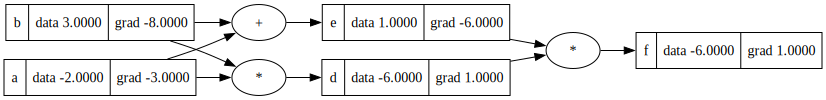

In [33]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
#continuing past visualization

In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#-----
#o = n.tanh()
e = (2*n).exp()
o = (e-1)/(e+1)
#-----

#instead of tanh we can use a different formula,
#we have impliment exponent and dividing methods so we can do this



o.label = 'o'

In [35]:
o.backward()

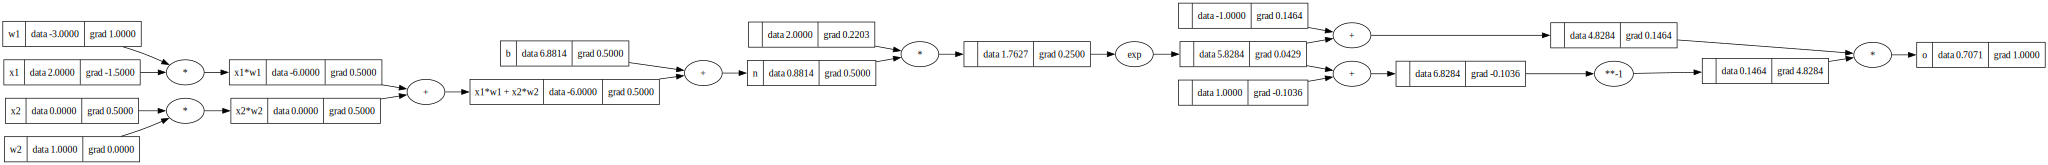

In [36]:
draw_dot(o)

In [3]:
import torch

In [4]:
# python defaults to float32 precision
# , setting to double here

# this demo in pytorch is doing what this project is emulating

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b                                               
o = torch.tanh(n)                                ; o.retain_grad()      # not needed but added to show 1:1

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# our outputs are the exact same as the engine

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
x2.grad.item()

0.5000001283844369

In [37]:
import random as rd

In [115]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(rd.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(rd.uniform(-1,1))


  def __call__(self,x):
    # w * x + b

    # summing weights and adding bias
    # starting with self.b in the zip
    tot = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = tot.tanh()

    return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    
    return x


In [116]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.264012378087911)

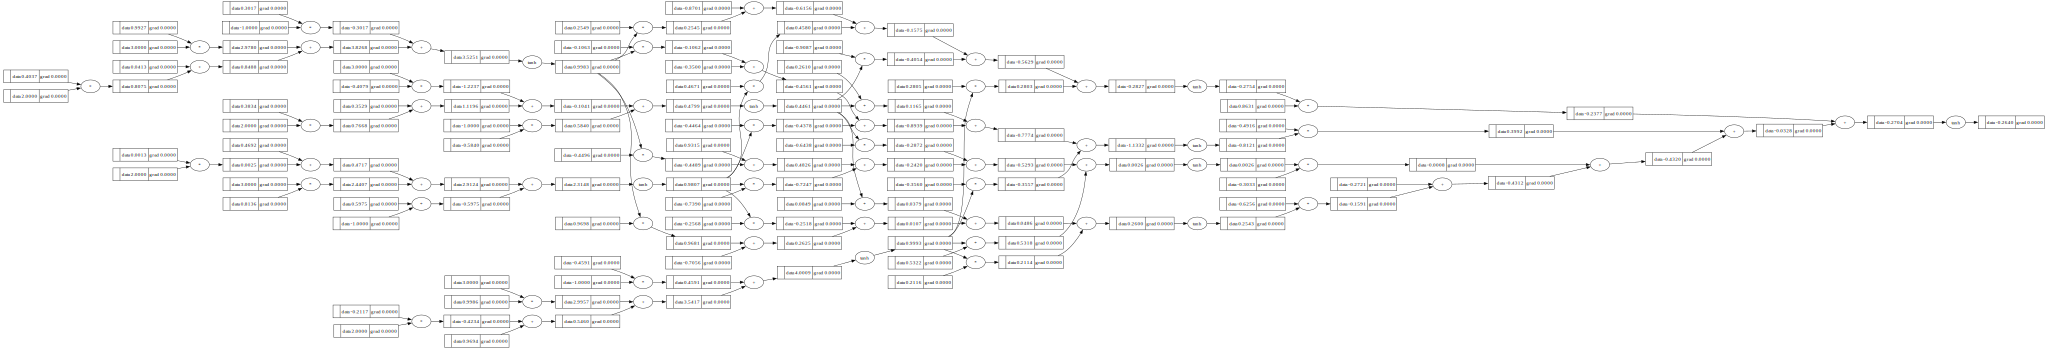

In [117]:
draw_dot(n(x))